In [48]:
import numpy as np
import matplotlib.pyplot as plt
# from scipy.integrate import solve_ivp

np.set_printoptions(precision=3, suppress=True)

plt.style.use([
    'grid',
    'science',
    'notebook',
    'high-vis',
])

In [49]:
Ts = .5
tf = 2500

iterations = int(tf/Ts)

time = np.linspace(0, tf, iterations)

r = .31
mu = .40
sigma = .55
A2 = np.pi * r**2

In [50]:
z1_bounds = np.array([-.5160, 2.3060])
z2_bounds = np.array([.0033, .0077])
z3_bounds = np.array([3.4478, 18.4570])

def M1(Z1):
    return (z1_bounds[1] - Z1)/(z1_bounds[1] - z1_bounds[0])

def N1(Z2):
    return (z2_bounds[1] - Z2)/(z2_bounds[1] - z2_bounds[0])

def O1(Z3):
    return (z3_bounds[1] - Z3)/(z3_bounds[1] - z3_bounds[0])

def M2(Z1):
    return 1-M1(Z1)

def N2(Z2):
    return 1-N1(Z2)

def O2(Z3):
    return 1-O1(Z3)

pertinence_functions = np.array([
    [M1, M2],
    [N1, N2],
    [O1, O2]
])

In [51]:
# controladores

K1 = np.array([
    [-8.2697, 8.3062]
])

K2 = np.array([
    [1.6772, -1.6953]
])

K3 = np.array([
    [1.9335, -1.9547]
])

K4 = np.array([
    [1.6770, -1.6950]
])

K5 = np.array([
    [1.9025, -1.9236]
])

K6 = np.array([
    [1.6464, -1.6647]
])

K7 = np.array([
    [1.8666, -1.8874]
])

K8 = np.array([
    [18.6160, -19.1036]
])

K = np.empty((8, 1, 2))

K[0] = K1
K[1] = K2
K[2] = K3
K[3] = K4
K[4] = K5
K[5] = K6
K[6] = K7
K[7] = K8

Ka = np.empty((8, 1))

Ka[0] = -0.0331e3
Ka[1] = .0227
Ka[2] = .0267
Ka[3] = .0227
Ka[4] = .0266
Ka[5] = .0235
Ka[6] = .0264
Ka[7] = .7051

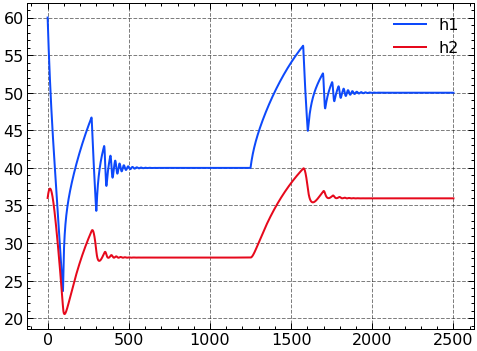

In [55]:
h1_t = np.zeros(iterations)
h2_t = np.zeros(iterations)
u_t  = np.zeros(iterations)

h1_0 = 60
h2_0 = 36

h1_t[0] = h1_0
h2_t[0] = h2_0

h1 = h1_0
h2 = h2_0

n = 8

A_matrices = [np.load(f'./data/vertices/A_{i}.npy') for i in range(n)]
B_matrices = [np.load(f'./data/vertices/B_{i}.npy') for i in range(n)]


def ds_dt(_, s, Ai, Bi, u):
    _h1, _h2 = s

    h = np.array([
        [_h1],
        [_h2]
    ])

    d_sys = Ai@h + Bi*u

    return d_sys.flatten()


e = .25
v = .0

refs = np.ones(iterations)

refs[int(iterations/2):] = 50
refs[:int(iterations/2)] = 40

for i in range(1, iterations):
    t = time[i]

    h = np.array([
        [h1],
        [h2]
    ])

    diff = h1 - h2

    R12 = (0.2371*diff+6.9192)*10
    q0  = (18.6367*h2+700.6831)*1e-4
    a1 = (3*r/5)*(2.7*r-((np.cos(2.5*np.pi*(h1-8)*1e-2-mu))/(sigma*np.sqrt(2*np.pi)))*np.exp(-(((h1-8)*1e-2-mu)**2)/(2*sigma**2)))

    Z1 = 1/R12
    Z2 = q0/h2
    Z3 = 1/a1
    
    v += (refs[i] - h1) * Ts
    
    mf_system = np.array([
        [pertinence_functions[0, 1](Z1), pertinence_functions[0, 0](Z1)],
        [pertinence_functions[1, 1](Z2), pertinence_functions[1, 0](Z2)],
        [pertinence_functions[2, 1](Z3), pertinence_functions[2, 0](Z3)],
    ])

    mf_controller = (1-e) * mf_system

    W = np.array([
        mf_system[0, 1] * mf_system[1, 1] * mf_system[2, 1],
        mf_system[0, 1] * mf_system[1, 1] * mf_system[2, 0],
        mf_system[0, 1] * mf_system[1, 0] * mf_system[2, 1],
        mf_system[0, 1] * mf_system[1, 0] * mf_system[2, 0],
        mf_system[0, 0] * mf_system[1, 1] * mf_system[2, 1],
        mf_system[0, 0] * mf_system[1, 1] * mf_system[2, 0],
        mf_system[0, 0] * mf_system[1, 0] * mf_system[2, 1],
        mf_system[0, 0] * mf_system[1, 0] * mf_system[2, 0],
    ])

    M = np.array([
        mf_controller[0, 1] * mf_controller[1, 1] * mf_controller[2, 1],
        mf_controller[0, 1] * mf_controller[1, 1] * mf_controller[2, 0],
        mf_controller[0, 1] * mf_controller[1, 0] * mf_controller[2, 1],
        mf_controller[0, 1] * mf_controller[1, 0] * mf_controller[2, 0],
        mf_controller[0, 0] * mf_controller[1, 1] * mf_controller[2, 1],
        mf_controller[0, 0] * mf_controller[1, 1] * mf_controller[2, 0],
        mf_controller[0, 0] * mf_controller[1, 0] * mf_controller[2, 1],
        mf_controller[0, 0] * mf_controller[1, 0] * mf_controller[2, 0],
    ])

    gain = sum( (K[j] * M[j])@h  for j in range(n))[0, 0]
    u_k  = -sum( (Ka[j] * M[j] * v) for j in range(n))[0]

    uf = np.clip(
        u_k+gain,
        0,
        100
    )

    Ai = sum([A_matrices[j] * W[j] for j in range(n)])
    Bi = sum([B_matrices[j] * W[j] for j in range(n)])

    # sol = solve_ivp(
    #     ds_dt,
    #     t_span=(t, t+Ts),
    #     y0=[h1, h2],
    #     t_eval=(t, t+Ts),
    #     args=(Ai, Bi, uf),
    #     method='RK23'
    # )

    # h1, h2 = sol.y[:, -1]

    delta_sys = Ai@h + Bi*uf

    h1 += delta_sys[0, 0] * Ts
    h2 += delta_sys[1, 0] * Ts

    h1_t[i] = h1
    h2_t[i] = h2

    u_t[i] = uf

plt.plot(time, h1_t, '-', label='h1')
plt.plot(time, h2_t, '-', label='h2')
plt.legend()

In [53]:
np.save('./data/h3_py.npy', h1_t)
np.save('./data/h4_py.npy', h2_t)